In [1]:
import pandas as pd
from utils import *
import os
from sklearn import preprocessing
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
result_dir='algorithm_classification_results'
iteration_min, iteration_max=0,29
algorithm_names=['DE','PSO','ES']
seeds=[200,400,600,800,1000]
visualization_dir='algorithm_classification_visualizations'
all_dimensions=[3,5,10,20]

In [3]:
os.makedirs(visualization_dir,exist_ok=True)

In [4]:
def tsne_features(feature_df_subset):
    feature_df_subset_scaled = preprocessing.StandardScaler().fit_transform(feature_df_subset.drop(columns=['y']))

    feature_df_subset_scaled_2d=TSNE(n_components=2).fit_transform(feature_df_subset_scaled)
    feature_df_subset_scaled_2d=pd.DataFrame(feature_df_subset_scaled_2d)
    feature_df_subset_scaled_2d.columns=['x','y']
    feature_df_subset_scaled_2d.index=feature_df_subset.index
    return feature_df_subset_scaled_2d

In [5]:
all_dimensions_feature_dfs={}
for dimension_index, dimension in enumerate(all_dimensions):
    for normalize_y in [False,True]:
        feature_df_file=f'{result_dir}_normalize_{normalize_y}/dim_{dimension}_{"-".join(algorithm_names)}_seeds_{"-".join([str(s) for s in seeds])}_it_{iteration_min}-{iteration_max}'
        if os.path.isfile(feature_df_file):
            print('reading features from file')
            feature_df=pd.read_csv(feature_df_file, index_col=[0,1,2,3])

        else:
            print('recalculating features')
            sample_df=read_trajectory_data(algorithm_names,seeds,dimension)
            sample_df=sample_df.query('iteration>=@iteration_min and iteration<=@iteration_max')
            if normalize_y:
                sample_df=normalize(sample_df,dimension)
            feature_df = extract_features(sample_df, dimension, iteration_min, iteration_max)
            feature_df.to_csv(feature_df_file)
        all_dimensions_feature_dfs[(dimension, normalize_y)]=feature_df

reading features from file
reading features from file
reading features from file
reading features from file
reading features from file
reading features from file
reading features from file
reading features from file


/tmp/ipykernel_120981/2873410136.py:17: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(data=tsne_features(feature_df_subset),ax=ax, x='x', y='y', hue='algorithm_name', style='seed', palette=[light_blue,lime,dark_blue, grey], alpha=1)
/tmp/ipykernel_120981/2873410136.py:17: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(data=tsne_features(feature_df_subset),ax=ax, x='x', y='y', hue='algorithm_name', style='seed', palette=[light_blue,lime,dark_blue, grey], alpha=1)
/tmp/ipykernel_120981/2873410136.py:17: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(data=tsne_features(feature_df_subset),ax=ax, x='x', y='y', hue='algorithm_name', style='seed', palette=[light_blue,lime,dark_blue, grey], alpha=1)
/tmp/ipykernel_120981/2873410136.py:17: UserWarning: The palette list has more values (4) than needed (

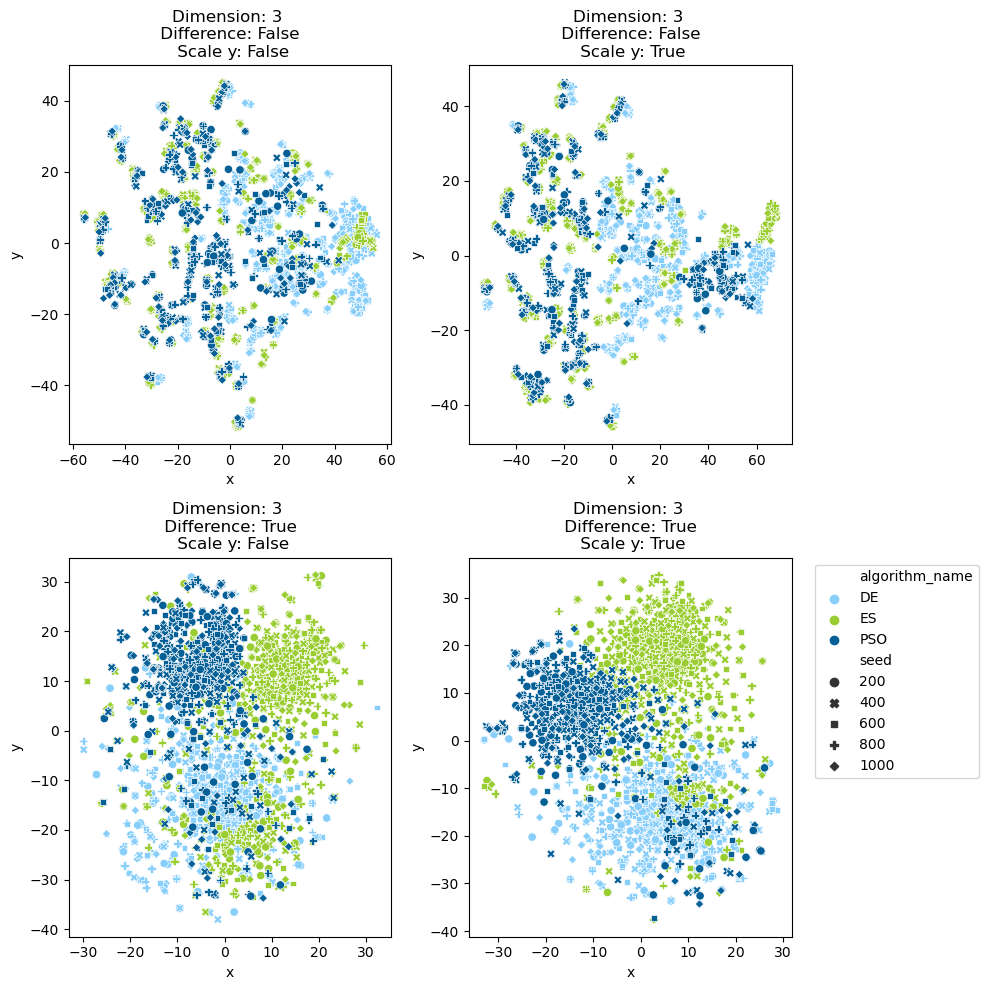

In [13]:
fig,axes=plt.subplots(2,2, figsize=(10,10))
for dimension_index, dimension in enumerate([3]):
    for normalize_y_index, normalize_y in enumerate([False,True]):
        feature_df=all_dimensions_feature_dfs[(dimension,normalize_y)]

        feature_df_subset = feature_df.dropna().query('instance_id<=5')

        for difference_index, difference in enumerate([False,True]):
            if difference:
                feature_df_subset=difference_features(feature_df_subset,iteration_max)
                feature_names=list(filter(lambda x: x!='y', feature_df.columns))
            else:
                feature_names=[f'{j} it_{it} ' + (f'x_{i}' if i < dimension else 'y') for it in range(iteration_min, iteration_max+1)  for j in ['mean','min','max','std'] for i in range(0,dimension+1) ]  


            ax=axes[difference_index][normalize_y_index]
            sns.scatterplot(data=tsne_features(feature_df_subset),ax=ax, x='x', y='y', hue='algorithm_name', style='seed', palette=[light_blue,lime,dark_blue, grey], alpha=1)
            
            ax.set_title(f'Dimension: {dimension} \n Difference: {difference} \n Scale y: {normalize_y}')
            if difference_index != 0 and normalize_y_index==1:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            else: 
                ax.get_legend().remove()

plt.tight_layout()
plt.savefig(os.path.join(visualization_dir,f'differencing_impact_dims_3.pdf'))
#plt.savefig(os.path.join(visualization_dir,f'differencing_impact_dim_{dimension}_differenced_{difference}.pdf'))
plt.show()

In [ ]:
fig,axes=plt.subplots(4,2, figsize=(8,16))
for dimension_index, dimension in enumerate(all_dimensions):
    
    feature_df=all_dimensions_feature_dfs[dimension]

    feature_df_subset = feature_df.dropna().query('instance_id<=3 and seed==200')

    for difference in [False,True]:
        if difference:
            differenced_feature_df_subset=difference_features(feature_df_subset,iteration_max)
            feature_names=list(filter(lambda x: x!='y', feature_df.columns))
        else:
            feature_names=[f'{j} it_{it} ' + (f'x_{i}' if i < dimension else 'y') for it in range(iteration_min, iteration_max+1)  for j in ['mean','min','max','std'] for i in range(0,dimension+1) ]  
        


    sns.scatterplot(data=tsne_features(feature_df_subset),ax=axes[dimension_index][0], x='x', y='y', hue='problem_id', style='problem_id', palette=[light_blue,lime,dark_blue, grey,dark_cyan], alpha=1)
    sns.scatterplot(data=tsne_features(differenced_feature_df_subset),ax=axes[dimension_index][1], x='x', y='y', hue='problem_id', style='problem_id', palette=[light_blue,lime,dark_blue, grey,dark_cyan], alpha=1)
    
    axes[dimension_index][0].set_title(f'Dimension: {dimension}, original features')
    axes[dimension_index][1].set_title(f'Dimension: {dimension}, differenced features')
    if dimension_index != 0:
        axes[dimension_index][0].get_legend().remove()
        axes[dimension_index][1].get_legend().remove()
    else:
        axes[dimension_index][1].get_legend().remove()
    
plt.tight_layout()
plt.savefig(os.path.join(visualization_dir,f'differencing_impact_all_dimensions_1.pdf'))
#plt.savefig(os.path.join(visualization_dir,f'differencing_impact_dim_{dimension}_differenced_{difference}.pdf'))
plt.show()